In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from itertools import product
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Functions

In [2]:
# Define the size categories
def classify_radius(size):
    if size <= 15:
        return 0.1  # Small size
    elif 16 <= size <= 140:
        return 0.3 # Medium size
    else:
        return 0.5  # Large size

In [3]:
# Add jitter to coordinates to reduce overlap
def jitter_coordinates(lat, lon, max_jitter=3.0):
    jittered_lat = lat + np.random.uniform(-max_jitter, max_jitter)
    jittered_lon = lon + np.random.uniform(-max_jitter, max_jitter)
    return jittered_lat, jittered_lon

# Specifications

In [4]:
optimal_cluster = 'default'
name = ''
save = True
save_data = False

if optimal_cluster == 'default':
    optimal_cluster = 'st_cluster_3_5_7'
    name = ''
    folder = ''
else:
    folder = 'SI/'

# Load Data

In [5]:
claims_clusters = pd.read_csv('../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv')
# Ensure that 'countyCode' is properly formatted as a 5-character string
claims_clusters['countyCode'] = claims_clusters['countyCode'].astype(int).astype(str)
claims_clusters['countyCode'] = claims_clusters['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_3306/1599268303.py:1: DtypeWarning: Columns (7,25,32,35,38,42,51,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  claims_clusters = pd.read_csv('../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv')


In [6]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 
#CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/CPI_by_Year_Month.csv") for homeowners insurance CPI

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims_cluster to only include those from 1998 to present
claims_clusters['dateOfLoss'] = pd.to_datetime(claims_clusters['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
claims_clusters.loc[:, 'yearOfLoss'] = claims_clusters['dateOfLoss'].dt.year

# Merge claims_clusters with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(claims_clusters, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])
claims_merged = claims_merged.drop(columns=['Year'])

# Create new field for 'totalClaimPaid'
claims_merged['totalClaimPaid'] = claims_merged['amountPaidOnBuildingClaim'].fillna(0) + claims_merged['amountPaidOnContentsClaim'].fillna(0)

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

claims_clusters = claims_merged
if save_data:
    claims_clusters.to_csv("adjusted_claims_clustered.csv")

/tmp/ipykernel_3306/3827937173.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_3306/3827937173.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_3306/3827937173.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an

# Using Storm Clustering

In [7]:
# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

In [8]:
# Katrina
katrina = 4
katrina_numbers =[4520, 1707, 1561, 1246, 2187, 1481] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: katrina if x in katrina_numbers else x
)

# Sandy
sandy = 87
sandy_numbers =[1603, 1507, 1252] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: sandy if x in sandy_numbers else x
)

# Harvey
harvey = 327
harvey_numbers =[3430, 5719, 5614, 5712, 5678, 5611, 1456, 1736] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: harvey if x in harvey_numbers else x
)

# Ian
ian = 166
ian_numbers =[3907, 4050] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: ian if x in ian_numbers else x
)

# ike
ike = 8
ike_numbers =[222, 1559, 1419] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: ike if x in ike_numbers else x
)

# la_2016
la_2016 = 295
la_2016_numbers =[3731, 2086, 2053, 3617, 3557] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: la_2016 if x in la_2016_numbers else x
)

# ivan
ivan = 6
ivan_numbers =[159, 164, 434, 143, 364, 4003, 4459]

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: ivan if x in ivan_numbers else x
)

# helene
helene = 190
helene_numbers =[195] 

claims_clusters[optimal_cluster] = claims_clusters[optimal_cluster].apply(
    lambda x: helene if x in helene_numbers else x
)

In [9]:
# Group by optimal_cluster and calculate medians and sizes
cluster_centers = claims_clusters.groupby(optimal_cluster).agg(
    median_latitude=('latitude', 'median'),
    median_longitude=('longitude', 'median'),
    cluster_size=('latitude', 'size'),  # Count rows in each cluster
    claim_sum=('adjustedClaim', 'sum'), # Median of the claim_sum for color mapping
    median_date=("dateOfLoss", "median") 
).reset_index()

# Calculate the 90th and 50th percentiles of the cluster_size
percentile_90 = np.percentile(cluster_centers['cluster_size'], 90)
percentile_50 = np.percentile(cluster_centers['cluster_size'], 50)

# Print the results
print(f"90th Percentile of cluster sizes: {percentile_90}")
print(f"50th Percentile (Median) of cluster sizes: {percentile_50}")

90th Percentile of cluster sizes: 139.0
50th Percentile (Median) of cluster sizes: 15.0


## Calculations of Interest

In [10]:
# Sort by claim_sum value to plot higher values last
cluster_centers = cluster_centers.sort_values(by='claim_sum', ascending=True)

# Classify cluster sizes into the three categories
cluster_centers['radius'] = cluster_centers['cluster_size'].apply(classify_radius)

sum_unclustered = claims_clusters[claims_clusters[optimal_cluster] == -1]['adjustedClaim'].sum()
annual_unclustered = float(sum_unclustered)/(claims_clusters['yearOfLoss'].max()-claims_clusters['yearOfLoss'].min())

average_claim_sum = cluster_centers['claim_sum'].mean()

sum_hist = 831697554.47
sum_2024 = 3879323216

# Total sum of 'claim_sum'
total_claim_sum = cluster_centers['claim_sum'].sum()
top_10_sum = cluster_centers.nlargest(10, 'claim_sum')['claim_sum'].sum()
top_8_sum = cluster_centers.nlargest(8, 'claim_sum')['claim_sum'].sum()

# Sum of all others except the top 20
sum_except_top_10 = total_claim_sum - top_10_sum
sum_except_top_8 = total_claim_sum - top_8_sum

# Extract year from the 'median_date' column
cluster_centers['year'] = pd.to_datetime(cluster_centers['median_date']).dt.year

# Group by year and count clusters
clusters_per_year = cluster_centers.groupby('year')[optimal_cluster].nunique()

# Calculate the average number of clusters per year
average_clusters_per_year = clusters_per_year.mean()

# Sort the DataFrame by 'claim_sum' in descending order
cluster_centers = cluster_centers.sort_values(by='claim_sum', ascending=False)

# Select the top 3 rows
top_3_clusters = cluster_centers.head(3)
top_8_clusters = cluster_centers.head(8)

# Assign names to the rows
top_3_clusters['Event'] = ["Hurricane Katrina", "Hurricane Harvey", "Hurricane Sandy"]
top_8_clusters['Event'] = ["Hurricane Katrina", "Hurricane Sandy", "Hurricane Harvey", "Hurricane Ian", "Hurricane Ike", "2016 Louisiana Flooding", "Hurricane Ivan", "Hurricane Helene"]

/tmp/ipykernel_3306/1072662926.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_clusters['Event'] = ["Hurricane Katrina", "Hurricane Harvey", "Hurricane Sandy"]
/tmp/ipykernel_3306/1072662926.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_8_clusters['Event'] = ["Hurricane Katrina", "Hurricane Sandy", "Hurricane Harvey", "Hurricane Ian", "Hurricane Ike", "2016 Louisiana Flooding", "Hurricane Ivan", "Hurricane Helene"]


In [11]:
cluster_centers.head(15)

,st_cluster_3_5_7,median_latitude,median_longitude,cluster_size,claim_sum,median_date,radius,year
5,4,30.0,-90.0,156549,2.561611e+10,2005-08-29,0.5,2005
88,87,40.4,-74.0,135611,1.171124e+10,2012-10-29,0.5,2012
323,327,29.8,-95.3,77624,1.149198e+10,2017-08-27,0.5,2017
164,166,26.5,-81.9,38026,4.992188e+09,2022-09-28,0.5,2022
9,8,29.5,-94.8,48199,3.831534e+09,2008-09-13,0.5,2008
291,295,30.4,-91.0,28088,3.285617e+09,2016-08-13,0.5,2016
7,6,30.4,-81.9,39764,3.116747e+09,2004-09-16,0.5,2004
0,-1,37.8,-86.6,151723,2.886284e+09,2003-03-21,0.5,2003
188,190,27.9,-82.7,27175,2.478798e+09,2024-09-26,0.5,2024
308,312,29.8,-95.3,30156,1.865877e+09,2001-06-09,0.5,2001


In [12]:
# Convert 'dateOfLoss' to datetime if not already
claims_clusters['dateOfLoss'] = pd.to_datetime(claims_clusters['dateOfLoss'])

# Define the target date
target_date = pd.Timestamp("2008-09-13")

# Group by 'var' and calculate the median dateOfLoss
median_dates = claims_clusters.groupby(optimal_cluster)['dateOfLoss'].median().reset_index()

# Calculate the absolute difference from the target date
median_dates['difference'] = (median_dates['dateOfLoss'] - target_date).abs()

# Sort by the difference
sorted_median_dates = median_dates.sort_values('difference')

# Display the results
print(sorted_median_dates[[optimal_cluster, 'dateOfLoss']].head(20))

      st_cluster_3_5_7 dateOfLoss
5021              5050 2008-09-13
9                    8 2008-09-13
2336              2356 2008-09-12
5034              5063 2008-09-12
4989              5018 2008-09-12
6304              6338 2008-09-11
4662              4691 2008-09-10
4467              4495 2008-09-06
1139              1145 2008-09-06
4458              4486 2008-09-06
4691              4720 2008-09-06
4072              4099 2008-09-06
6622              6656 2008-09-06
3966              3991 2008-09-06
3128              3148 2008-09-06
4428              4455 2008-09-06
4673              4702 2008-09-25
6674              6708 2008-09-25
6659              6693 2008-09-25
4529              4558 2008-09-25


In [13]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

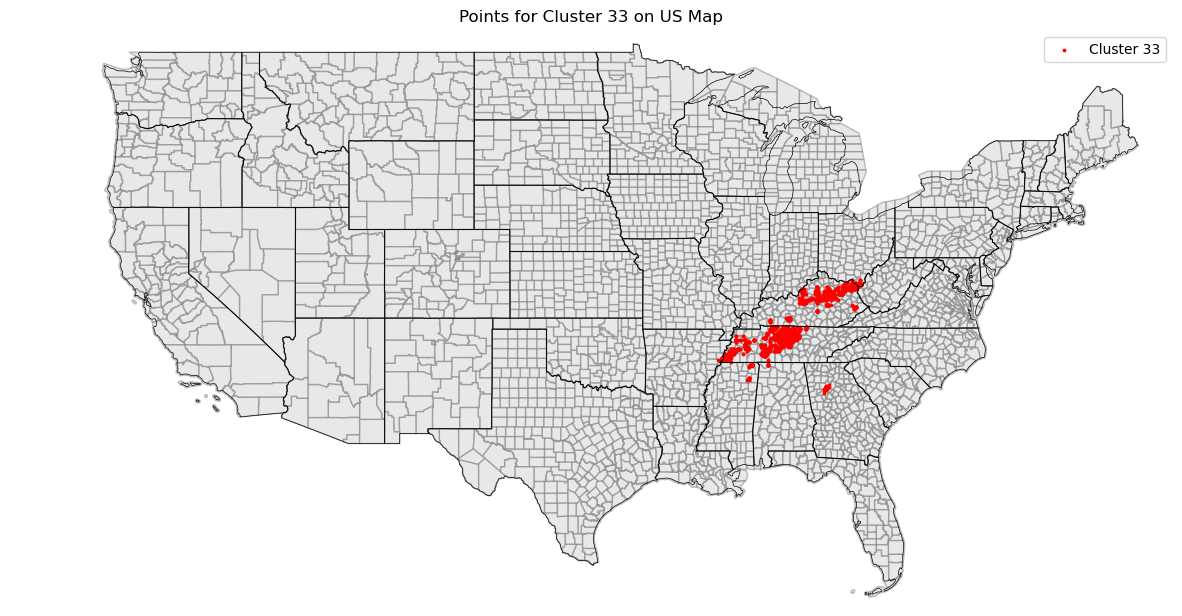

In [14]:
# In common: 26, 32, 33, 160, 163, 169, 192 (1979, 2010, 2011, 1993, 1983, 1995, 2001)

claim_num = 33

extent=[-130, -65, 24, 50]

# Filter for points in the specified cluster
cluster_points = claims_clusters[claims_clusters[optimal_cluster] == claim_num] #178, 4193, 1923, 1276

# 1388, 1272, 1201, 1007

# Create a GeoDataFrame for the points
gdf_claims_all = gpd.GeoDataFrame(
    cluster_points,
    geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
    crs="EPSG:4326"
)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot counties and states
gdf_counties.plot(ax=ax, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot the cluster points
gdf_claims_all.plot(ax=ax, color='red', markersize=3, label=f'Cluster {claim_num}')

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')

# Add legend and labels
plt.legend()
plt.title(f"Points for Cluster {claim_num} on US Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [15]:
# Data for the first chart
data1 = {
    "Type": ["Unclustered", "Mean\nCluster"],
    "Value": [annual_unclustered/1000000, average_claim_sum/1000000]
}

# Data for the second chart
data2 = {
    "Type": ["99.9% Hyperclusters", "All Other Claims"],
    "Value": [top_8_sum/1000000000, sum_except_top_8/1000000000]
}

# Assign names to the rows
top_3_clusters['Event'] = ["Hurricane\nKatrina", "Hurricane\nHarvey", "Hurricane\nSandy"]
top_3_clusters['claim_sum'] = top_3_clusters['claim_sum']/1000000000

top_8_clusters['Event'] = ["Hurricane\nKatrina", "Hurricane\nSandy", "Hurricane\nHarvey", "Hurricane\nIan", "Hurricane\nIke", "Louisiana\nFlood 2016", "Hurricane\nIvan", "Hurricane\nHelene"]
["Hurricane\nKatrina", "Hurricane\nHarvey", "Hurricane \nSandy", "Hurricane\nIke", "Louisiana\nFlood 2016"]
top_8_clusters['claim_sum'] = top_8_clusters['claim_sum']/1000000000

# Convert to DataFrames
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

/tmp/ipykernel_3306/1555882809.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_clusters['Event'] = ["Hurricane\nKatrina", "Hurricane\nHarvey", "Hurricane\nSandy"]
/tmp/ipykernel_3306/1555882809.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_clusters['claim_sum'] = top_3_clusters['claim_sum']/1000000000
/tmp/ipykernel_3306/1555882809.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [16]:
# Sort the DataFrame by 'claim_sum' in descending order
cluster_centers = cluster_centers.sort_values(by='claim_sum', ascending=False)

# Select the top 10 rows
billion_dollar = cluster_centers[cluster_centers[optimal_cluster] != -1].head(12)

# Sort the DataFrame by 'claim_sum' in ascending order
billion_dollar = billion_dollar.sort_values(by='claim_sum', ascending=True)

# Extract year from 'median_date' and add it as a new column
billion_dollar['year'] = pd.to_datetime(billion_dollar['median_date']).dt.year

# Define radius using log scale for 'claim_sum'
min_claim_sum = billion_dollar['claim_sum'].min()
log_base = 10  # You can adjust the base for scaling if needed
max_radius = 3  # Maximum radius for visualization
billion_dollar['radius'] = (
    billion_dollar['cluster_size'] / billion_dollar['cluster_size'].max() * max_radius
)

# Apply jittering to each cluster's coordinates
billion_dollar[['jittered_latitude', 'jittered_longitude']] = billion_dollar.apply(
    lambda row: jitter_coordinates(row['median_latitude'], row['median_longitude']), axis=1, result_type="expand"
)

/tmp/ipykernel_3306/1279499836.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cluster_centers['claim_sum'].fillna(1e4, inplace=True)  # Replace NaN with a small value (e.g., 1e-1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/srv/conda/envs/notebook/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: There are no gridspecs

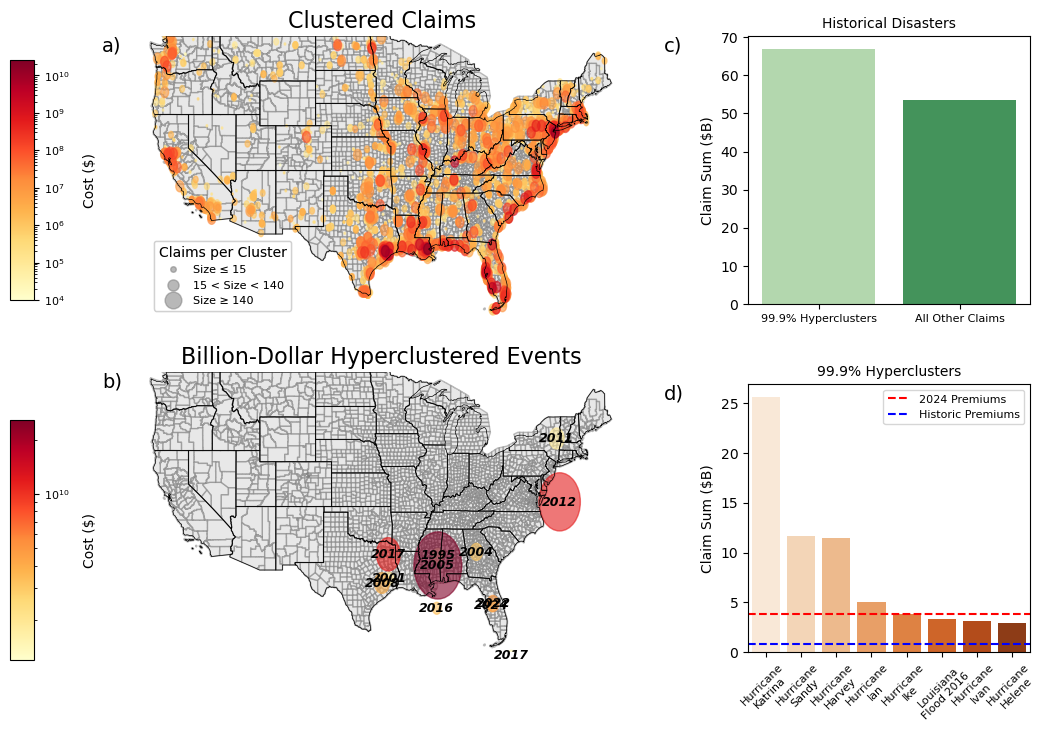

In [17]:
# Define the overall figure with a grid layout
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(2, 2, width_ratios=[2, 1])  # 2 rows, 2 columns with narrow barplot column

# Limit to contiguous US (approximate bounding box)
extent = [-125, -66.5, 24, 49]  # [min_lon, max_lon, min_lat, max_lat]

# First column: Maps
ax_map1 = fig.add_subplot(gs[0, 0])
ax_map2 = fig.add_subplot(gs[1, 0])

# Second column: Nested GridSpec for bar plots
gs_bar = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[:, 1], height_ratios=[1, 1], hspace=0.3)  # Adjusted hspace
bar_axes = [fig.add_subplot(gs_bar[i, 0]) for i in range(2)]  # Create individual bar plot axes

# Sort by claim_sum value to plot higher values last
cluster_centers = cluster_centers.sort_values(by='claim_sum', ascending=True)

# Determine the min and max of the claim_sum
cluster_centers['claim_sum'] = cluster_centers['claim_sum'].replace([np.inf, -np.inf], np.nan)
cluster_centers['claim_sum'].fillna(1e4, inplace=True)  # Replace NaN with a small value (e.g., 1e-1)
cluster_centers['claim_sum'] = cluster_centers['claim_sum'].apply(lambda x: max(x, 1e4))  # Replace with a small positive number
vmin = cluster_centers['claim_sum'].min()
vmax = cluster_centers['claim_sum'].max()

# Update color map to yellow-to-red
cmap_yellow_red = plt.cm.YlOrRd

# Log normalization for color mapping
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Map the claim_sum to colors
cluster_centers['color'] = cluster_centers['claim_sum'].apply(lambda x: cmap_yellow_red(norm(x)) if not np.isnan(x) else 'gray')

# Plot 1: Map of all clusters
gdf_counties.plot(ax=ax_map1, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax_map1, color='black', linewidth=0.5)

patches1 = []
for _, row in cluster_centers.iterrows():
    center = (row['median_longitude'], row['median_latitude'])
    radius = row['radius']
    color = row['color']
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.6)
    patches1.append(circle)

p1 = PatchCollection(patches1, match_original=True, transform=ax_map1.transData)
ax_map1.add_collection(p1)

ax_map1.set_xlim(extent[0], extent[1])
ax_map1.set_ylim(extent[2], extent[3])
ax_map1.axis('off')
ax_map1.set_title("Clustered Claims", fontsize=16)

# Add subplot label "a)" in the upper left
ax_map1.text(-0.1, 1, "a)", transform=ax_map1.transAxes, fontsize=14, va='top', ha='left')

# Add legend for point sizes with varying sizes
legend_elements = [
    Line2D([0], [0], marker='o', color='gray', markersize=4, label='Size ≤ 15', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=8, label='15 < Size < 140', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=12, label='Size ≥ 140', linestyle='None', alpha=0.5),
]

legend = ax_map1.legend(handles=legend_elements, loc='lower left', title='Claims per Cluster', frameon=True, fontsize=8)
ax_map1.add_artist(legend)

# Add first colorbar (left-aligned for the first map)
cbar_ax1 = fig.add_axes([0.05, 0.55, 0.02, 0.3])  # [left, bottom, width, height]
sm1 = plt.cm.ScalarMappable(cmap=cmap_yellow_red, norm=norm)
cb1 = fig.colorbar(sm1, cax=cbar_ax1, orientation='vertical')
cb1.ax.tick_params(labelsize=8)
cb1.set_label('Cost ($)', fontsize=10, labelpad=10)

# Plot 2: Map of top 10 clusters
vmin = billion_dollar['claim_sum'].min()
vmax = billion_dollar['claim_sum'].max()
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
billion_dollar['color'] = billion_dollar['claim_sum'].apply(lambda x: cmap_yellow_red(norm(x)) if not np.isnan(x) else 'gray')

gdf_counties.plot(ax=ax_map2, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax_map2, color='black', linewidth=0.5)

patches2 = []
for _, row in billion_dollar.iterrows():
    center = (row['jittered_longitude'], row['jittered_latitude'])
    radius = row['radius']
    color = row['color']
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.6)
    patches2.append(circle)

    ax_map2.text(
        center[0], center[1], str(row['year']),
        color='black', fontsize=9, style='italic', fontweight='bold', ha='center', va='center', zorder=5
    )

p2 = PatchCollection(patches2, match_original=True, transform=ax_map2.transData)
ax_map2.add_collection(p2)

ax_map2.set_xlim(extent[0], extent[1])
ax_map2.set_ylim(extent[2], extent[3])
ax_map2.axis('off')
ax_map2.set_title("Billion-Dollar Hyperclustered Events", fontsize=16)

# Add subplot label "b)" in the upper left
ax_map2.text(-0.1, 1, "b)", transform=ax_map2.transAxes, fontsize=14, va='top', ha='left')

# Add second colorbar (left-aligned for the second map)
cbar_ax2 = fig.add_axes([0.05, 0.1, 0.02, 0.3])  # Adjust position to align with the second map
sm2 = plt.cm.ScalarMappable(cmap=cmap_yellow_red, norm=norm)
cb2 = fig.colorbar(sm2, cax=cbar_ax2, orientation='vertical')
cb2.ax.tick_params(labelsize=8)
cb2.set_label('Cost ($)', fontsize=10, labelpad=10)

# Bar Plot 1: Historical Disasters
sns.barplot(ax=bar_axes[0], data=df2, x="Type", y="Value", palette="Greens")
bar_axes[0].set_title("Historical Disasters", fontsize=10)
bar_axes[0].set_ylabel("Claim Sum ($B)")
bar_axes[0].set_xlabel("")
bar_axes[0].set_xticklabels(bar_axes[0].get_xticklabels(), fontsize=8)

# Add subplot label "c)" in the upper left
bar_axes[0].text(-0.3, 1, "c)", transform=bar_axes[0].transAxes, fontsize=14, va='top', ha='left')

sns.barplot(ax=bar_axes[1], data=top_8_clusters, x="Event", y="claim_sum", palette="Oranges")
bar_axes[1].set_title("99.9% Hyperclusters", fontsize=10)
bar_axes[1].set_ylabel("Claim Sum ($B)")
bar_axes[1].set_xlabel("")
bar_axes[1].set_xticklabels(bar_axes[1].get_xticklabels(), fontsize=8, rotation=45)

# Add horizontal lines to the third bar plot
bar_axes[1].axhline(sum_2024/1000000000, color='red', linestyle='--', label="2024 Premiums")
bar_axes[1].axhline(sum_hist/1000000000, color='blue', linestyle='--', label="Historic Premiums")
bar_axes[1].legend(loc='upper right', fontsize=8)

# Add subplot label "d)" in the upper left
bar_axes[1].text(-0.3, 1, "d)", transform=bar_axes[1].transAxes, fontsize=14, va='top', ha='left')

if save:
    output_path = 'Plots/F2_Clusters.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Adjust layout
plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/srv/conda/envs/notebook/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/srv/conda/envs/notebook/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/srv/conda/envs/notebook/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/tmp/ipykernel_3306/1636016136.py:123: FutureWarning: 

Passing `palette` withou

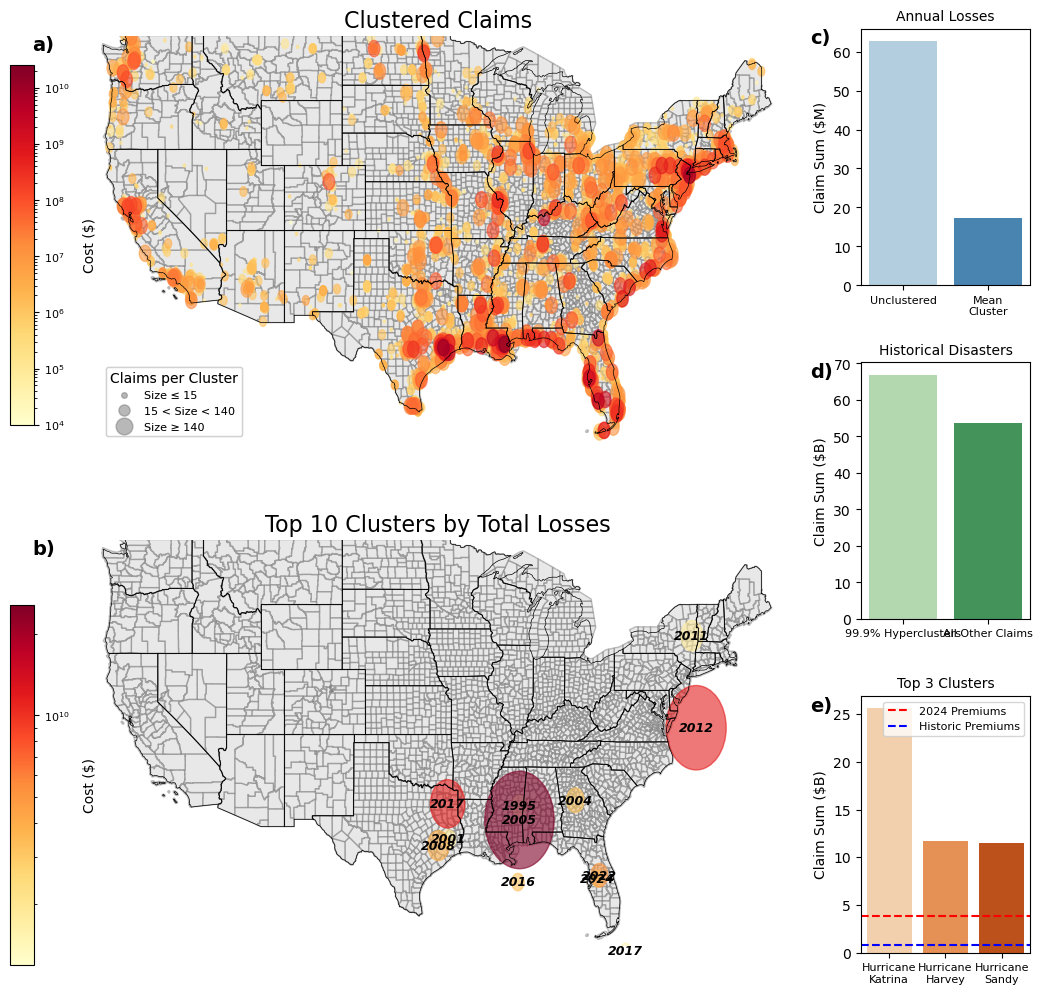

In [18]:
# Define the overall figure with a grid layout
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = GridSpec(2, 2, width_ratios=[4, 1])  # 2 rows, 2 columns with narrow barplot column

# Limit to contiguous US (approximate bounding box)
extent = [-125, -66.5, 24, 49]  # [min_lon, max_lon, min_lat, max_lat]

# First column: Maps
ax_map1 = fig.add_subplot(gs[0, 0])
ax_map2 = fig.add_subplot(gs[1, 0])

# Second column: Nested GridSpec for bar plots
gs_bar = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[:, 1], height_ratios=[1, 1, 1], hspace=0.3)  # Adjusted hspace
bar_axes = [fig.add_subplot(gs_bar[i, 0]) for i in range(3)]  # Create individual bar plot axes

# Sort by claim_sum value to plot higher values last
cluster_centers = cluster_centers.sort_values(by='claim_sum', ascending=True)

# Determine the min and max of the claim_sum
vmin = cluster_centers['claim_sum'].min()
vmax = cluster_centers['claim_sum'].max()

# Update color map to yellow-to-red
cmap_yellow_red = plt.cm.YlOrRd

# Log normalization for color mapping
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Map the claim_sum to colors
cluster_centers['color'] = cluster_centers['claim_sum'].apply(lambda x: cmap_yellow_red(norm(x)) if not np.isnan(x) else 'gray')

# Plot 1: Map of all clusters
gdf_counties.plot(ax=ax_map1, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax_map1, color='black', linewidth=0.5)

patches1 = []
for _, row in cluster_centers.iterrows():
    center = (row['median_longitude'], row['median_latitude'])
    radius = row['radius']
    color = row['color']
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.6)
    patches1.append(circle)

p1 = PatchCollection(patches1, match_original=True, transform=ax_map1.transData)
ax_map1.add_collection(p1)

ax_map1.set_xlim(extent[0], extent[1])
ax_map1.set_ylim(extent[2], extent[3])
ax_map1.axis('off')
ax_map1.set_title("Clustered Claims", fontsize=16)

# Add subplot label "a)" in the upper left
ax_map1.text(-0.1, 1, "a)", transform=ax_map1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add legend for point sizes with varying sizes
legend_elements = [
    Line2D([0], [0], marker='o', color='gray', markersize=4, label='Size ≤ 15', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=8, label='15 < Size < 140', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=12, label='Size ≥ 140', linestyle='None', alpha=0.5),
]

legend = ax_map1.legend(handles=legend_elements, loc='lower left', title='Claims per Cluster', frameon=True, fontsize=8)
ax_map1.add_artist(legend)

# Add first colorbar (left-aligned for the first map)
cbar_ax1 = fig.add_axes([0.05, 0.55, 0.02, 0.3])  # [left, bottom, width, height]
sm1 = plt.cm.ScalarMappable(cmap=cmap_yellow_red, norm=norm)
cb1 = fig.colorbar(sm1, cax=cbar_ax1, orientation='vertical')
cb1.ax.tick_params(labelsize=8)
cb1.set_label('Cost ($)', fontsize=10, labelpad=10)

# Plot 2: Map of top 10 clusters

# Determine the min and max of the claim_sum
vmin = billion_dollar['claim_sum'].min()
vmax = billion_dollar['claim_sum'].max()

# Update color map to yellow-to-red
cmap_yellow_red = plt.cm.YlOrRd

# Log normalization for color mapping
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Map the claim_sum to colors
billion_dollar['color'] = billion_dollar['claim_sum'].apply(lambda x: cmap_yellow_red(norm(x)) if not np.isnan(x) else 'gray')

gdf_counties.plot(ax=ax_map2, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax_map2, color='black', linewidth=0.5)

patches2 = []
for _, row in billion_dollar.iterrows():
    center = (row['jittered_longitude'], row['jittered_latitude'])
    radius = row['radius']
    color = row['color']
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.6)
    patches2.append(circle)

    # Add text annotation for year
    ax_map2.text(
        center[0], center[1], str(row['year']),
        color='black', fontsize=9, style='italic', fontweight='bold', ha='center', va='center', zorder=5
    )

p2 = PatchCollection(patches2, match_original=True, transform=ax_map2.transData)
ax_map2.add_collection(p2)

ax_map2.set_xlim(extent[0], extent[1])
ax_map2.set_ylim(extent[2], extent[3])
ax_map2.axis('off')
ax_map2.set_title("Top 10 Clusters by Total Losses", fontsize=16)

# Add subplot label "b)" in the upper left
ax_map2.text(-0.1, 1, "b)", transform=ax_map2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add second colorbar (left-aligned for the second map)
cbar_ax2 = fig.add_axes([0.05, 0.1, 0.02, 0.3])  # Adjust position to align with the second map
sm2 = plt.cm.ScalarMappable(cmap=cmap_yellow_red, norm=norm)
cb2 = fig.colorbar(sm2, cax=cbar_ax2, orientation='vertical')
cb2.ax.tick_params(labelsize=8)
cb2.set_label('Cost ($)', fontsize=10, labelpad=10)

# Bar Plot 1: Annual Losses
sns.barplot(ax=bar_axes[0], data=df1, x="Type", y="Value", palette="Blues")
bar_axes[0].set_title("Annual Losses", fontsize=10)
bar_axes[0].set_ylabel("Claim Sum ($M)")
bar_axes[0].set_xlabel("")
bar_axes[0].set_xticklabels(bar_axes[0].get_xticklabels(), fontsize=8)

# Add subplot label "c)" in the upper left
bar_axes[0].text(-0.3, 1, "c)", transform=bar_axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Bar Plot 2: Historical Disasters
sns.barplot(ax=bar_axes[1], data=df2, x="Type", y="Value", palette="Greens")
bar_axes[1].set_title("Historical Disasters", fontsize=10)
bar_axes[1].set_ylabel("Claim Sum ($B)")
bar_axes[1].set_xlabel("")
bar_axes[1].set_xticklabels(bar_axes[1].get_xticklabels(), fontsize=8)

# Add subplot label "d)" in the upper left
bar_axes[1].text(-0.3, 1, "d)", transform=bar_axes[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Bar Plot 3: Top 3 Clusters
sns.barplot(ax=bar_axes[2], data=top_3_clusters, x="Event", y="claim_sum", palette="Oranges")
bar_axes[2].set_title("Top 3 Clusters", fontsize=10)
bar_axes[2].set_ylabel("Claim Sum ($B)")
bar_axes[2].set_xlabel("")
bar_axes[2].set_xticklabels(bar_axes[2].get_xticklabels(), fontsize=8)

# Add horizontal lines to the third bar plot
bar_axes[2].axhline(sum_2024/1000000000, color='red', linestyle='--', label="2024 Premiums")
bar_axes[2].axhline(sum_hist/1000000000, color='blue', linestyle='--', label="Historic Premiums")
bar_axes[2].legend(loc='upper right', fontsize=8)

# Add subplot label "e)" in the upper left
bar_axes[2].text(-0.3, 1, "e)", transform=bar_axes[2].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')


if save:
    output_path = 'Plots/Fig_4.png'
    #plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Adjust layout
plt.show()

In [19]:
def plot_with_trendline(x, y, ax, xlabel, ylabel):
    # Scatter plot
    ax.scatter(x, y, label='Data points', alpha=0.7)

    # Fit a linear trendline
    coefficients = np.polyfit(x, y, 1)
    trendline = np.poly1d(coefficients)

    # Compute R² value
    y_pred = trendline(x)
    residuals = y - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Plot the trendline
    x_line = np.linspace(min(x), max(x), 100)
    y_line = trendline(x_line)
    ax.plot(x_line, y_line, color='red', label=f'Trendline (R² = {r2:.2f})')

    # Label axes and add legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

KeyError: 'return_periodMax'

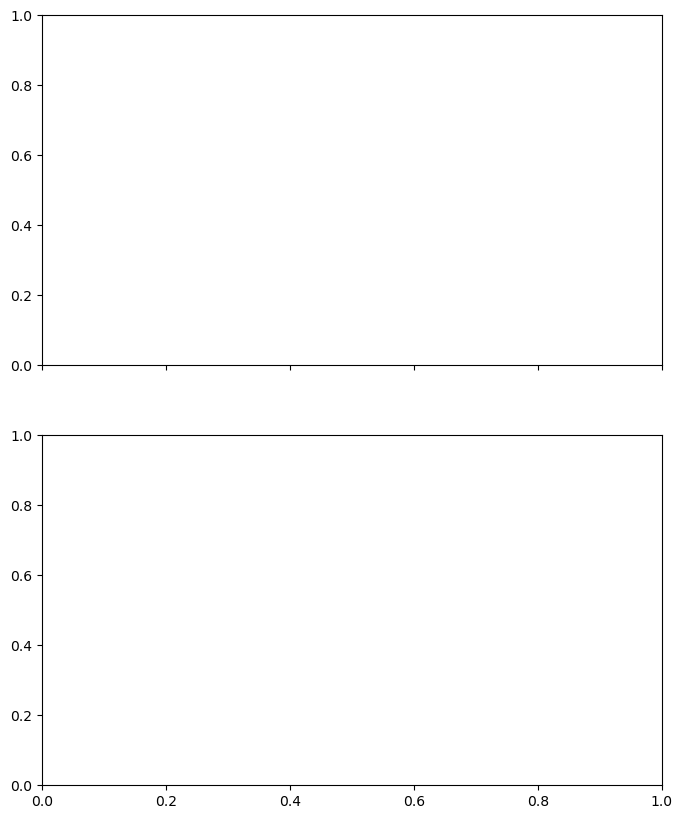

In [20]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot first scatter plot with trendline
plot_with_trendline(
    cluster_centers['claim_sum'],
    cluster_centers['return_periodMax'],
    axes[0],
    'Claim Sum',
    'Return Period Max'
)

# Plot second scatter plot with trendline
plot_with_trendline(
    cluster_centers['claim_sum'],
    cluster_centers['return_periodMean'],
    axes[1],
    'Claim Sum',
    'Return Period Mean'
)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()